Make a Dask Array

In [127]:
from dask.array import from_array
from numpy import array

A = array(range(15)).reshape((1,15))
chunks = (1,5)
d = from_array(A, chunks=chunks)
d

dask.array<array, shape=(1, 15), dtype=int64, chunksize=(1, 5), chunktype=numpy.ndarray>

In [128]:
d.compute().shape

(1, 15)

Convert the blocks to Numpy matrices (instead of ndarrays):

In [129]:
from numpy import matrix

In [130]:
m = d.map_blocks(matrix, chunks=chunks)
m

dask.array<matrix, shape=(1, 15), dtype=int64, chunksize=(1, 5), chunktype=numpy.matrix>

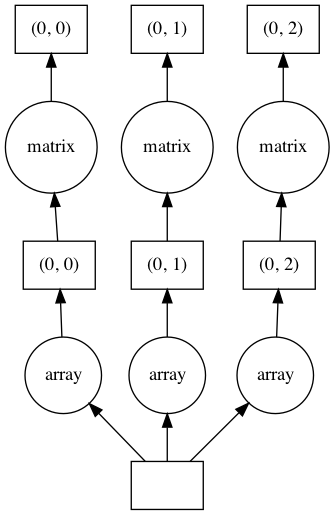

In [131]:
m.visualize()

In [132]:
import numpy as np

In [133]:
np.concatenate(r, axis=0), np.concatenate(r, axis=1)

(matrix([[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14]]),
 matrix([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]]))

Should get a 1x15 matrix, instead get 3x5; the side-to-side chunks should be concatenated along axis 1, but instead are stacked as rows (axis 0):

In [134]:
m.compute(scheduler='synchronous')

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [153]:
m.sum(axis=0).compute(scheduler='synchronous')

TypeError: sum() got an unexpected keyword argument 'keepdims'

In [135]:
m.__dask_keys__()

[[('matrix-d04698f7a55d84da285bc7a83bb798bb', 0, 0),
  ('matrix-d04698f7a55d84da285bc7a83bb798bb', 0, 1),
  ('matrix-d04698f7a55d84da285bc7a83bb798bb', 0, 2)]]

In [136]:
m.__dask_postcompute__()

(<function dask.array.core.finalize(results)>, ())

### Innards of `compute`:

In [137]:
from dask.base import unpack_collections, get_scheduler, collections_to_dsk

args = (m,)
kwargs = dict()

traverse = kwargs.pop("traverse", True)
optimize_graph = kwargs.pop("optimize_graph", True)

collections, repack = unpack_collections(*args, traverse=traverse)

schedule = get_scheduler(
    scheduler=kwargs.pop("scheduler", None),
    collections=collections,
    get=kwargs.pop("get", None),
)

dsk = collections_to_dsk(collections, optimize_graph, **kwargs)
keys, postcomputes = [], []
for x in collections:
    keys.append(x.__dask_keys__())
    postcomputes.append(x.__dask_postcompute__())

results = schedule(dsk, keys, **kwargs)
repack([f(r, *a) for r, (f, a) in zip(results, postcomputes)])

(array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]]),)

In [138]:
d.compute()

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [142]:
results[0][0]

(matrix([[0, 1, 2, 3, 4]]),
 matrix([[5, 6, 7, 8, 9]]),
 matrix([[10, 11, 12, 13, 14]]))

In [143]:
results

(((matrix([[0, 1, 2, 3, 4]]),
   matrix([[5, 6, 7, 8, 9]]),
   matrix([[10, 11, 12, 13, 14]])),),)

In [144]:
postcomputes

[(<function dask.array.core.finalize(results)>, ())]

In [145]:
r, (f, a) = list(zip(results, postcomputes))[0]

In [146]:
r, f, a

(((matrix([[0, 1, 2, 3, 4]]),
   matrix([[5, 6, 7, 8, 9]]),
   matrix([[10, 11, 12, 13, 14]])),),
 <function dask.array.core.finalize(results)>,
 ())

In [147]:
r

((matrix([[0, 1, 2, 3, 4]]),
  matrix([[5, 6, 7, 8, 9]]),
  matrix([[10, 11, 12, 13, 14]])),)

In [149]:
results

(((matrix([[0, 1, 2, 3, 4]]),
   matrix([[5, 6, 7, 8, 9]]),
   matrix([[10, 11, 12, 13, 14]])),),)

In [150]:
f(r, *a)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [151]:
[f(r, *a) for r, (f, a) in zip(results, postcomputes)]

[array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])]

In [152]:
results

(((matrix([[0, 1, 2, 3, 4]]),
   matrix([[5, 6, 7, 8, 9]]),
   matrix([[10, 11, 12, 13, 14]])),),)

In [38]:
finalize

<function dask.array.core.finalize(results)>

In [48]:
r

(matrix([[0, 1, 2, 3, 4]]),
 matrix([[5, 6, 7, 8, 9]]),
 matrix([[10, 11, 12, 13, 14]]))

In [74]:
m.ndim, m.shape

(1, (15,))

In [75]:
m.blocks[0].ndim

1

In [72]:
r[0].ndim

2

In [60]:
from dask.array.core import concatenate3, _concatenate2

In [68]:
_concatenate2(r, axes=range(2))

matrix([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

In [71]:
_concatenate2(r, axes=[0])

matrix([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

In [70]:
_concatenate2(r, axes=[1])

matrix([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [62]:
from dask.utils import ndimlist
ndimlist(r)

1

In [65]:
from dask.array.core import chunks_from_arrays, unpack_singleton

In [81]:
unpack_singleton(r)

matrix([[0, 1, 2, 3, 4]])

In [67]:
unpack_singleton(r).ndim

2

In [64]:
chunks_from_arrays(r)

((1, 1, 1),)

In [52]:
r[0].__array_function__

<function matrix.__array_function__>

In [51]:
concatenate3(r)

matrix([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

In [47]:
isinstance(r, (tuple, list))

True

In [46]:
from dask.array.core import finalize
finalize(results[0], *a)

matrix([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

In [40]:
f(results)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [41]:
finalize(r)

matrix([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

In [30]:
postcomputes

[(<function dask.array.core.finalize(results)>, ())]

In [7]:
d.compute()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [89]:
arrays = r
from dask.array.utils import IS_NEP18_ACTIVE
from dask.utils import concrete
from dask import core

# We need this as __array_function__ may not exist on older NumPy versions.
# And to reduce verbosity.
NDARRAY_ARRAY_FUNCTION = getattr(np.ndarray, "__array_function__", None)

arrays = concrete(arrays)
if not arrays:
    raise Exception(np.empty(0))

advanced = max(
    core.flatten(arrays, container=(list, tuple)),
    key=lambda x: getattr(x, "__array_priority__", 0),
)

In [95]:
m.chunks

((5, 5, 5),)

In [98]:
m.blocks.shape

AttributeError: 'IndexCallable' object has no attribute 'shape'

In [102]:
r[0].ravel(), r[0].flatten()

(matrix([[0, 1, 2, 3, 4]]), matrix([[0, 1, 2, 3, 4]]))

In [103]:
r[0].A.ravel(), r[0].A.flatten()

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In [90]:
arrays

[matrix([[0, 1, 2, 3, 4]]),
 matrix([[5, 6, 7, 8, 9]]),
 matrix([[10, 11, 12, 13, 14]])]

In [99]:
_concatenate2([arrays], axes=[0,1])

matrix([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [99]:
_concatenate2([arrays], axes=[0,1])

matrix([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [93]:
_concatenate2(arrays, axes=[0])

matrix([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

In [94]:
_concatenate2(arrays, axes=[1])

matrix([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

In [88]:
if IS_NEP18_ACTIVE and not all(
    NDARRAY_ARRAY_FUNCTION
    is getattr(arr, "__array_function__", NDARRAY_ARRAY_FUNCTION)
    for arr in arrays
):
    try:
        x = unpack_singleton(arrays)
        raise Exception(_concatenate2(arrays, axes=tuple(range(x.ndim))))
    except TypeError:
        pass

if concatenate_lookup.dispatch(type(advanced)) is not np.concatenate:
    x = unpack_singleton(arrays)
    raise Exception(_concatenate2(arrays, axes=list(range(x.ndim))))

ndim = ndimlist(arrays)
if not ndim:
    raise Exception(arrays)

chunks = chunks_from_arrays(arrays)
shape = tuple(map(sum, chunks))

def dtype(x):
    try:
        return x.dtype
    except AttributeError:
        return type(x)

result = np.empty(shape=shape, dtype=dtype(deepfirst(arrays)))

for (idx, arr) in zip(slices_from_chunks(chunks), core.flatten(arrays)):
    if hasattr(arr, "ndim"):
        while arr.ndim < ndim:
            arr = arr[None, ...]
    result[idx] = arr

result

Exception: [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]